In [9]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np

# Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Transform áp dụng cho các bộ dữ liệu
img2vec_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ảnh cho phù hợp với ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chọn bộ dữ liệu (thay đổi tên dataset để sử dụng bộ khác)
dataset_name = "CIFAR10"  # MNIST, STL10, SVHN, FashionMNIST, ...

if dataset_name == "CIFAR10":
    # Tải toàn bộ dữ liệu train, test
    full_train_dataset = datasets.CIFAR10(
        root='.',
        train=True,
        transform=img2vec_transforms,
        download=True
    )
    test_dataset = datasets.CIFAR10(
        root='.',
        train=False,
        transform=img2vec_transforms,
        download=True
    )

    # --------------------- TẠO TẬP TRAIN MẤT CÂN BẰNG ---------------------
    # Yêu cầu: lớp "frog" (label = 6) có số lượng gấp đôi mỗi lớp khác
    # và tổng số mẫu ~ 4000

    # Định nghĩa các tỉ lệ
    ratio_frog = 2      # frog gấp đôi
    ratio_other = 1     # các lớp còn lại
    total_size = 4000   # tổng số mẫu mong muốn

    # CIFAR10 có 10 lớp (0..9), trong đó frog_label = 6
    frog_label = 6
    num_classes = 10

    # Tính toán “đơn vị tỉ lệ”
    # Tổng tỉ lệ = ratio_frog + 9 * ratio_other = 2 + 9*1 = 11
    total_ratio = ratio_frog + (num_classes - 1) * ratio_other  # 11
    ratio_unit = total_size // total_ratio  # 4000 // 11 = 363
    remainder = total_size % total_ratio    # 4000 % 11 = 7

    # Số mẫu dành cho lớp frog (cộng remainder vào luôn)
    frog_needed = ratio_frog * ratio_unit + remainder  # 2*363 + 7 = 733
    # Số mẫu cho mỗi lớp còn lại
    other_needed = ratio_other * ratio_unit            # 1*363 = 363

    # Lấy mảng label của tập train
    labels = np.array(full_train_dataset.targets)

    # Tách chỉ số thuộc lớp frog
    frog_indices_all = np.where(labels == frog_label)[0]
    # Tách chỉ số của 9 lớp còn lại
    other_indices_dict = {}  # dict để lưu lớp -> danh sách index
    for c in range(num_classes):
        if c != frog_label:
            other_indices_dict[c] = np.where(labels == c)[0]

    # Random (sample) 733 mẫu cho frog
    frog_indices_chosen = np.random.choice(
        frog_indices_all,
        size=min(frog_needed, len(frog_indices_all)),  # an toàn nếu frog_needed > len(frog_indices_all)
        replace=False
    )

    # Random (sample) 363 mẫu cho mỗi lớp còn lại
    other_indices_chosen = []
    for c in other_indices_dict:
        chosen = np.random.choice(
            other_indices_dict[c],
            size=min(other_needed, len(other_indices_dict[c])),
            replace=False
        )
        other_indices_chosen.extend(chosen)

    # Gom tất cả index lại
    unbalanced_indices = list(frog_indices_chosen) + list(other_indices_chosen)
    # Tạo Subset cho train dataset
    unbalanced_train_dataset = Subset(full_train_dataset, unbalanced_indices)

else:
    # Các dataset khác, giữ nguyên cách load (hoặc bạn có thể chỉnh sửa tùy ý)
    if dataset_name == "STL10":
        unbalanced_train_dataset = datasets.STL10(
            root='.',
            split='train',
            transform=img2vec_transforms,
            download=True
        )
        test_dataset = datasets.STL10(
            root='.',
            split='test',
            transform=img2vec_transforms,
            download=True
        )
    elif dataset_name == "SVHN":
        unbalanced_train_dataset = datasets.SVHN(
            root='.',
            split='train',
            transform=img2vec_transforms,
            download=True
        )
        test_dataset = datasets.SVHN(
            root='.',
            split='test',
            transform=img2vec_transforms,
            download=True
        )
    elif dataset_name == "FashionMNIST":
        grayscale_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        unbalanced_train_dataset = datasets.FashionMNIST(
            root='.',
            train=True,
            transform=grayscale_transform,
            download=True
        )
        test_dataset = datasets.FashionMNIST(
            root='.',
            train=False,
            transform=grayscale_transform,
            download=True
        )
    elif dataset_name == "MNIST":
        grayscale_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
        unbalanced_train_dataset = datasets.MNIST(
            root='.',
            train=True,
            transform=grayscale_transform,
            download=True
        )
        test_dataset = datasets.MNIST(
            root='.',
            train=False,
            transform=grayscale_transform,
            download=True
        )
    else:
        raise ValueError(f"Dataset {dataset_name} không được hỗ trợ.")

# ----------------------------------------------------------------------
# Bước tiếp theo: Dataloader cho tập train "unbalanced" và test
# Ở đây ta đã chủ động dàn xếp số mẫu = 4000, nên không cần cắt nữa.
# Nếu vẫn muốn cắt tiếp, bạn có thể bật lại các dòng Subset bên dưới.
# ----------------------------------------------------------------------
# sample_size = 4000
# subset_indices_train = list(range(min(sample_size, len(unbalanced_train_dataset))))
# subset_train = Subset(unbalanced_train_dataset, subset_indices_train)
# dataloader_train = DataLoader(subset_train, batch_size=128, shuffle=False)

# Hoặc dùng luôn unbalanced_train_dataset (4000 mẫu)
dataloader_train = DataLoader(unbalanced_train_dataset, batch_size=128, shuffle=False)

# Test dataset - giữ nguyên hoặc subset 4000 cho nhanh
subset_indices_test = list(range(min(4000, len(test_dataset))))
subset_test = Subset(test_dataset, subset_indices_test)
dataloader_test = DataLoader(subset_test, batch_size=128, shuffle=False)

# ----------------------------------------------------------------------
# Mô hình ResNet-50 mặc định
# ----------------------------------------------------------------------
resnet_default = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
# Xóa bỏ lớp fully connected cuối (fc) để lấy embedding
resnet_default.fc = torch.nn.Identity()
resnet_default.eval()

# Hàm tính embedding
def get_embeddings(model, dataloader):
    embeddings = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            emb = model(images).cpu()
            embeddings.append(emb)
    return torch.cat(embeddings, dim=0)

# Lấy embedding cho train và test
embedding_default_train = get_embeddings(resnet_default, dataloader_train)
embedding_default_test = get_embeddings(resnet_default, dataloader_test)

print(f"Embedding train ({dataset_name}):", embedding_default_train.shape)
print(f"Embedding test ({dataset_name}):", embedding_default_test.shape)


Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
Embedding train (CIFAR10): torch.Size([4000, 2048])
Embedding test (CIFAR10): torch.Size([4000, 2048])


In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, Subset
import numpy as np

In [1]:
# Bật autoreload
%load_ext autoreload
%autoreload 2

In [10]:
# resnet_default_test -> valid/ test
# resnet_default_train -> train
embedding_default_valid = embedding_default_test[2000:]
embedding_default_test = embedding_default_test[:2000]
embedding_default_train = embedding_default_train.numpy()
print(embedding_default_valid.shape)
print(embedding_default_test.shape)
print(embedding_default_train.shape)

torch.Size([2000, 2048])
torch.Size([2000, 2048])
(4000, 2048)


In [11]:
def get_labels(dataloader):
    labels = []
    with torch.no_grad():
        for _, label in dataloader:
            labels.append(label)
    return torch.cat(labels, dim=0)

In [12]:
finetuned_label_train = get_labels(dataloader_train)
finetuned_label_test = get_labels(dataloader_test)
print(finetuned_label_train.shape)
print(finetuned_label_test.shape)

torch.Size([4000])
torch.Size([4000])


In [13]:
finetuned_label_train = finetuned_label_train.numpy()
finetuned_label_valid = finetuned_label_test[2000:]
finetuned_label_test = finetuned_label_test[:2000]
finetuned_label_valid = finetuned_label_valid.numpy()
finetuned_label_test = finetuned_label_test.numpy()

In [14]:
# save
import pickle

with open('x_y_embedding_cifar_imbalance.pkl', 'wb') as f:
    #pickle.dump((x_embeddings, y_labels, xt_embeddings, yt_labels), f)
    pickle.dump((embedding_default_train, finetuned_label_train, embedding_default_valid, finetuned_label_valid, embedding_default_test, finetuned_label_test), f)

In [15]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_cifar_imbalance.pkl', 'rb') as f:
    #x_embeddings, y_labels, xt_embeddings, yt_labels = pickle.load(f)
    embedding_default_train, finetuned_label_train, embedding_default_valid, finetuned_label_valid, embedding_default_test, finetuned_label_test = pickle.load(f)
x_embeddings = embedding_default_train
y_labels = finetuned_label_train
xt_embeddings = embedding_default_test
yt_labels = finetuned_label_test
print("Training embeddings shape:", x_embeddings.shape)
print("Training labels shape:", y_labels.shape)
print("Validation embeddings shape:", xt_embeddings.shape)
print("Validation labels shape:", yt_labels.shape)

Training embeddings shape: (4000, 2048)
Training labels shape: (4000,)
Validation embeddings shape: torch.Size([2000, 2048])
Validation labels shape: (2000,)


In [16]:
from machine_learning_model import LogisticRegression
from nosify import mix_label

# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

Accuracy: 0.8868332874787266


In [18]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner, LavaEvaluator_batch, LavaEvaluator_batchl2l
knn_evaluator = KNNEvaluator(Ismetric= 1)
knn_evaluator1 = KNNEvaluator(Ismetric= 0)
cknn_evaluator1 = CKNNEvaluator(T = 20, default=False)
cknn_evaluator2 = CKNNEvaluator(T = 1000, default=False)
cknn_evaluator3 = CKNNEvaluator(T = 2000, default=False)
cknn_evaluator4 = CKNNEvaluator(T = 3000, default=False)
cknn_evaluator5 = CKNNEvaluator(T = 3900, default=False)
lava_evaluator_batch1 = LavaEvaluator_batch(batch = 512)
lava_evaluator_batch2 = LavaEvaluator_batch(batch = 2048)
lava_evaluator_batchl2l1 = LavaEvaluator_batchl2l(batch = 512)
lava_evaluator_batchl2l2 = LavaEvaluator_batchl2l(batch = 1024)
lava_evaluator_batchl2l3 = LavaEvaluator_batchl2l(batch = 2048)
lava_evaluator_OT = LavaEvaluator_OT()
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, knn_evaluator, cknn_evaluator1, cknn_evaluator2, cknn_evaluator3, cknn_evaluator4, cknn_evaluator5, lava_evaluator_batch1, lava_evaluator_batch2, lava_evaluator_batchl2l1, lava_evaluator_batchl2l2, lava_evaluator_batchl2l3, lava_evaluator_OT, lava_evaluator_geomloss])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)

Running evaluator: KNNEvaluator0


100%|██████████| 3999/3999 [00:03<00:00, 1131.64it/s]


KNNEvaluator0 completed in 7.20 seconds.
Running evaluator: KNNEvaluator1


100%|██████████| 3999/3999 [00:03<00:00, 1098.56it/s]


KNNEvaluator1 completed in 6.94 seconds.
Running evaluator: CKNNEvaluator2


100%|██████████| 3980/3980 [00:03<00:00, 1057.57it/s]


CKNNEvaluator2 completed in 7.60 seconds.
Running evaluator: CKNNEvaluator3


100%|██████████| 3000/3000 [00:02<00:00, 1036.09it/s]


CKNNEvaluator3 completed in 7.24 seconds.
Running evaluator: CKNNEvaluator4


100%|██████████| 2000/2000 [00:01<00:00, 1054.14it/s]


CKNNEvaluator4 completed in 6.79 seconds.
Running evaluator: CKNNEvaluator5


100%|██████████| 1000/1000 [00:00<00:00, 1087.22it/s]


CKNNEvaluator5 completed in 6.41 seconds.
Running evaluator: CKNNEvaluator6


100%|██████████| 100/100 [00:00<00:00, 900.23it/s]


CKNNEvaluator6 completed in 5.50 seconds.
Running evaluator: LavaEvaluator_batch7


batch LAVA:   0%|          | 0/8 [00:00<?, ?it/s]

































batch LAVA:  12%|█▎        | 1/8 [00:01<00:12,  1.79s/it]



































batch LAVA:  25%|██▌       | 2/8 [00:03<00:10,  1.81s/it]
































batch LAVA:  38%|███▊      | 3/8 [00:05<00:09,  1.87s/it]































batch LAVA:  50%|█████     | 4/8 [00:07<00:07,  1.80s/it]



































batch LAVA:  62%|██████▎   | 5/8 [00:09<00:05,  1.86s/it]
































batch LAVA:  75%|███████▌  | 6/8 [00:10<00:03,  1.83s/it]

































batch LAVA:  88%|████████▊ | 7/8 [00:12<00:01,  1.80s/it]



































batch LAVA: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


LavaEvaluator_batch7 completed in 14.39 seconds.
Running evaluator: LavaEvaluator_batch8


batch LAVA:   0%|          | 0/2 [00:00<?, ?it/s]


















batch LAVA:  50%|█████     | 1/2 [00:02<00:02,  2.48s/it]

















batch LAVA: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


LavaEvaluator_batch8 completed in 5.02 seconds.
Running evaluator: LavaEvaluator_batchl2l9


batch LAVA: 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]


LavaEvaluator_batchl2l9 completed in 4.96 seconds.
Running evaluator: LavaEvaluator_batchl2l10


batch LAVA: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


LavaEvaluator_batchl2l10 completed in 4.84 seconds.
Running evaluator: LavaEvaluator_batchl2l11


batch LAVA: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


LavaEvaluator_batchl2l11 completed in 5.87 seconds.
Running evaluator: LavaEvaluator_OT12


LavaEvaluator_OT12 completed in 2.62 seconds.
Running evaluator: LavaEvaluator_geomloss13


LavaEvaluator_geomloss13 completed in 5.68 seconds.


Running remove_low experiment...
position: 0
position: 400
position: 800
position: 1200
position: 1600
position: 2000
position: 2400
position: 2800
position: 3200
position: 3600


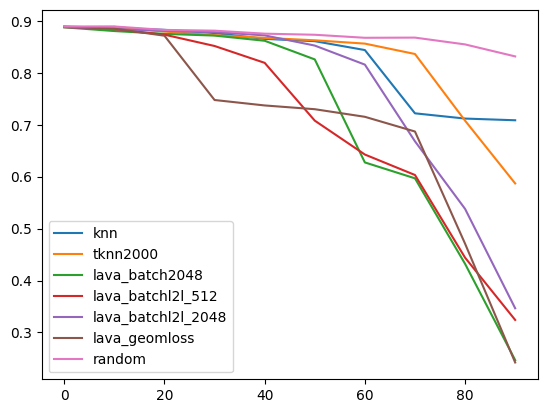

Running remove_high experiment...
position: 0
position: 400
position: 800
position: 1200
position: 1600
position: 2000
position: 2400
position: 2800
position: 3200
position: 3600


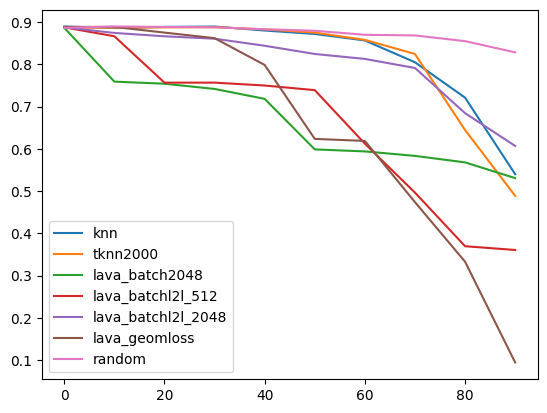

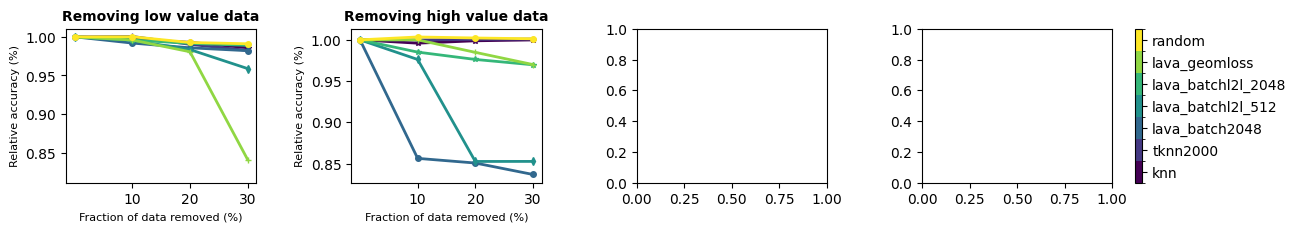

In [20]:
from experiment_run import run_experiments
seed = 2025
np.random.seed(seed)
rand_lst = []
shap_list = [value for value in results.values()]
rand_lst.append(np.random.rand(len(shap_list[0])))
name = ['knn', 'tknn2000', 'lava_batch2048','lava_batchl2l_512', 'lava_batchl2l_2048', 'lava_geomloss', 'random']
model = LogisticRegression(input_dim, num_classes)
values = [shap_list[0] , shap_list[3], shap_list[7], shap_list[8], shap_list[10],  shap_list[12], rand_lst[0]]
run_experiments(values, name, x_embeddings, y_labels, xt_embeddings, yt_labels, model)

In [22]:
from experiment_run import run_experiments

Running remove_low experiment...
position: 0
position: 400
position: 800
position: 1200
position: 1600
position: 2000
position: 2400
position: 2800
position: 3200
position: 3600


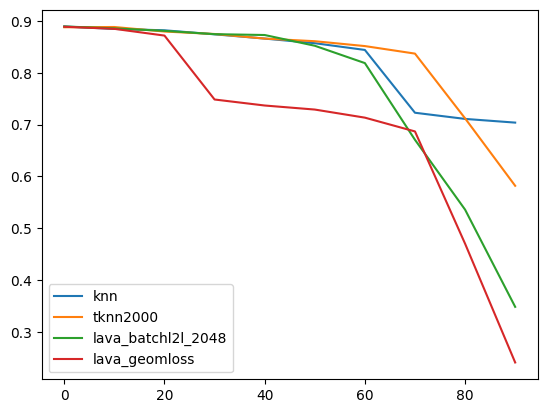

Running remove_high experiment...
position: 0
position: 400
position: 800
position: 1200
position: 1600
position: 2000
position: 2400
position: 2800
position: 3200
position: 3600


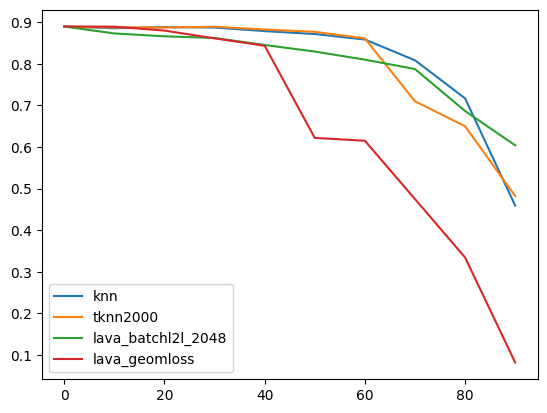

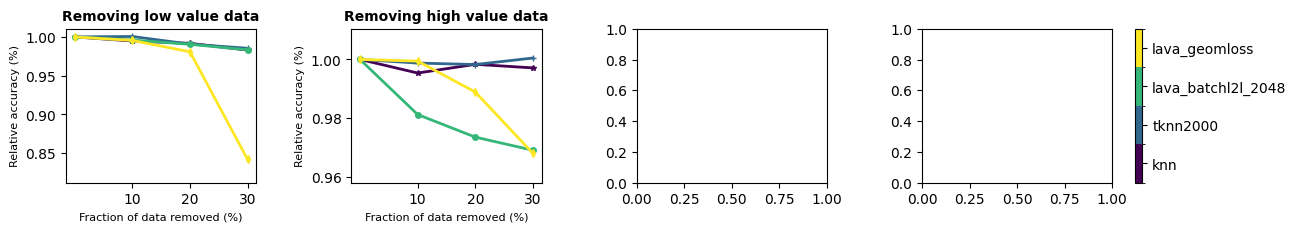

In [21]:
seed = 46
np.random.seed(seed)
rand_lst = []
shap_list = [value for value in results.values()]
rand_lst.append(np.random.rand(len(shap_list[0])))
#name = ['knn', 'tknn2000', 'lava_batchl2l_2048', 'lava_geomloss']
name = ['knn']
model = LogisticRegression(input_dim, num_classes)
#values = [shap_list[0] , shap_list[3], shap_list[10],  shap_list[12]]
values = [shap_list[0]]
run_experiments(values, name, x_embeddings, y_labels, xt_embeddings, yt_labels, model)

In [2]:
### Load x_y_embedding_data
import pickle
with open('x_y_embedding_cifar.pkl', 'rb') as f:
    #x_embeddings, y_labels, xt_embeddings, yt_labels = pickle.load(f)
    embedding_default_train, finetuned_label_train, embedding_default_valid, finetuned_label_valid, embedding_default_test, finetuned_label_test = pickle.load(f)
x_embeddings = embedding_default_train
y_labels = finetuned_label_train
xt_embeddings = embedding_default_test
yt_labels = finetuned_label_test
print("Training embeddings shape:", x_embeddings.shape)
print("Training labels shape:", y_labels.shape)
print("Validation embeddings shape:", xt_embeddings.shape)
print("Validation labels shape:", yt_labels.shape)

Training embeddings shape: (1000, 2048)
Training labels shape: (1000,)
Validation embeddings shape: (500, 2048)
Validation labels shape: (500,)


In [5]:
from machine_learning_model import LogisticRegression
from nosify import mix_label
param = mix_label(y_labels, yt_labels, noise_rate=0.2)
y_labels_noisy = param['y_train']
noisy_train_indices = param['noisy_train_indices']
print("Noisy training labels shape:", y_labels_noisy.shape)
# train model logistic regression
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
model.fit(x_embeddings, y_labels_noisy, epochs= 1000, lr = 0.1)
# predict
y_pred = model.predict(xt_embeddings)
# evaluate
from sklearn.metrics import f1_score, accuracy_score
accuracy = f1_score(yt_labels, y_pred, average='weighted')
print("Accuracy:", accuracy)

500
Noisy training labels shape: (1000,)
Accuracy: 0.6677099914404038


In [9]:
from base_evaluator import BaseEvaluator, KNNEvaluator,CKNNEvaluator ,LavaEvaluator_geomloss, LavaEvaluator_OT, ExperimentRunner, LavaEvaluator_batch, LavaEvaluator_batchl2l
knn_evaluator = KNNEvaluator(Ismetric= 1)
knn_evaluator1 = KNNEvaluator(Ismetric= 0)
cknn_evaluator1 = CKNNEvaluator(k_neighbors= 10, T = 20, default=False)
cknn_evaluator2 = CKNNEvaluator(k_neighbors = 10, T = 100, default=False)
cknn_evaluator3 = CKNNEvaluator(k_neighbors = 10, T = 500, default=False)
cknn_evaluator4 = CKNNEvaluator(k_neighbors = 10, T = 900, default=False)
cknn_evaluator5 = CKNNEvaluator(k_neighbors = 10, T = 980, default=False)

cknn_evaluator11 = CKNNEvaluator(k_neighbors = 3, T = 20, default=False)
cknn_evaluator21 = CKNNEvaluator(k_neighbors = 3, T = 100, default=False)
cknn_evaluator31 = CKNNEvaluator(k_neighbors = 3, T = 500, default=False)
cknn_evaluator41 = CKNNEvaluator(k_neighbors = 3, T = 900, default=False)
cknn_evaluator51 = CKNNEvaluator(k_neighbors = 3, T = 980, default=False)

cknn_evaluator12 = CKNNEvaluator(k_neighbors = 5, T = 20, default=False)
cknn_evaluator22 = CKNNEvaluator(k_neighbors = 5, T = 100, default=False)
cknn_evaluator32 = CKNNEvaluator(k_neighbors = 5, T = 500, default=False)
cknn_evaluator42 = CKNNEvaluator(k_neighbors = 5, T = 900, default=False)
cknn_evaluator52 = CKNNEvaluator(k_neighbors = 5, T = 980, default=False)

cknn_evaluator13 = CKNNEvaluator(k_neighbors = 8, T = 20, default=False)
cknn_evaluator23 = CKNNEvaluator(k_neighbors = 8, T = 100, default=False)
cknn_evaluator33 = CKNNEvaluator(k_neighbors = 8, T = 500, default=False)
cknn_evaluator43 = CKNNEvaluator(k_neighbors = 8, T = 900, default=False)
cknn_evaluator53 = CKNNEvaluator(k_neighbors = 8, T = 980, default=False)

cknn_evaluator14 = CKNNEvaluator(k_neighbors = 15, T = 20, default=False)
cknn_evaluator24 = CKNNEvaluator(k_neighbors = 15, T = 100, default=False)
cknn_evaluator34 = CKNNEvaluator(k_neighbors = 15, T = 500, default=False)
cknn_evaluator44 = CKNNEvaluator(k_neighbors = 15, T = 900, default=False)
cknn_evaluator54 = CKNNEvaluator(k_neighbors = 15, T = 980, default=False)

cknn_evaluator15 = CKNNEvaluator(k_neighbors = 20, T = 20, default=False)
cknn_evaluator25 = CKNNEvaluator(k_neighbors = 20, T = 100, default=False)
cknn_evaluator35 = CKNNEvaluator(k_neighbors = 20, T = 500, default=False)
cknn_evaluator45 = CKNNEvaluator(k_neighbors = 20, T = 900, default=False)
cknn_evaluator55 = CKNNEvaluator(k_neighbors = 20, T = 980, default=False)

cknn_evaluator16 = CKNNEvaluator(k_neighbors = 40, T = 20, default=False)
cknn_evaluator26 = CKNNEvaluator(k_neighbors = 40, T = 100, default=False)
cknn_evaluator36 = CKNNEvaluator(k_neighbors = 40, T = 500, default=False)
cknn_evaluator46 = CKNNEvaluator(k_neighbors = 40, T = 900, default=False)
cknn_evaluator56 = CKNNEvaluator(k_neighbors = 40, T = 980, default=False)

cknn_evaluator17 = CKNNEvaluator(k_neighbors = 50, T = 20, default=False)
cknn_evaluator27 = CKNNEvaluator(k_neighbors = 50, T = 100, default=False)
cknn_evaluator37 = CKNNEvaluator(k_neighbors = 50, T = 500, default=False)
cknn_evaluator47 = CKNNEvaluator(k_neighbors = 50, T = 900, default=False)
cknn_evaluator57 = CKNNEvaluator(k_neighbors = 50, T = 980, default=False)

cknn_evaluator18 = CKNNEvaluator(k_neighbors = 100, T = 20, default=False)
cknn_evaluator28 = CKNNEvaluator(k_neighbors = 100, T = 100, default=False)
cknn_evaluator38 = CKNNEvaluator(k_neighbors = 100, T = 500, default=False)
cknn_evaluator48 = CKNNEvaluator(k_neighbors = 100, T = 900, default=False)
cknn_evaluator58 = CKNNEvaluator(k_neighbors = 100, T = 980, default=False)

lava_evaluator_batch1 = LavaEvaluator_batch(batch = 256)
lava_evaluator_batch2 = LavaEvaluator_batch(batch = 512)
lava_evaluator_batchl2l1 = LavaEvaluator_batchl2l(batch = 256)
lava_evaluator_batchl2l2 = LavaEvaluator_batchl2l(batch = 512)
lava_evaluator_OT = LavaEvaluator_OT()
lava_evaluator_geomloss = LavaEvaluator_geomloss()
experiment = ExperimentRunner(evaluators=[knn_evaluator, knn_evaluator1, 
                                          cknn_evaluator1, cknn_evaluator2, cknn_evaluator3, cknn_evaluator4, cknn_evaluator5,
                                          cknn_evaluator12, cknn_evaluator22, cknn_evaluator32, cknn_evaluator42, cknn_evaluator52,
                                          cknn_evaluator13, cknn_evaluator23, cknn_evaluator33, cknn_evaluator43, cknn_evaluator53,
                                          cknn_evaluator14, cknn_evaluator24, cknn_evaluator34, cknn_evaluator44, cknn_evaluator54,
                                          cknn_evaluator15, cknn_evaluator25, cknn_evaluator35, cknn_evaluator45, cknn_evaluator55,
                                          cknn_evaluator16, cknn_evaluator26, cknn_evaluator36, cknn_evaluator46, cknn_evaluator56,
                                          cknn_evaluator17, cknn_evaluator27, cknn_evaluator37, cknn_evaluator47, cknn_evaluator57,
                                          cknn_evaluator18, cknn_evaluator28, cknn_evaluator38, cknn_evaluator48, cknn_evaluator58,
                                          lava_evaluator_batch1, lava_evaluator_batch2, lava_evaluator_batchl2l1, lava_evaluator_batchl2l2, 
                                          lava_evaluator_OT, lava_evaluator_geomloss])
results = experiment.run(x_embeddings, y_labels, xt_embeddings, yt_labels)

Running evaluator: KNNEvaluator0


100%|██████████| 999/999 [00:00<00:00, 3517.94it/s]


KNNEvaluator0 completed in 0.69 seconds.
Running evaluator: KNNEvaluator1


100%|██████████| 999/999 [00:00<00:00, 3456.98it/s]


KNNEvaluator1 completed in 0.54 seconds.
Running evaluator: CKNNEvaluator2


100%|██████████| 980/980 [00:00<00:00, 3708.98it/s]


CKNNEvaluator2 completed in 0.50 seconds.
Running evaluator: CKNNEvaluator3


100%|██████████| 900/900 [00:00<00:00, 3822.81it/s]


CKNNEvaluator3 completed in 0.49 seconds.
Running evaluator: CKNNEvaluator4


100%|██████████| 500/500 [00:00<00:00, 3668.70it/s]


CKNNEvaluator4 completed in 0.45 seconds.
Running evaluator: CKNNEvaluator5


100%|██████████| 100/100 [00:00<00:00, 3234.75it/s]


CKNNEvaluator5 completed in 0.47 seconds.
Running evaluator: CKNNEvaluator6


100%|██████████| 20/20 [00:00<00:00, 2472.18it/s]


CKNNEvaluator6 completed in 0.47 seconds.
Running evaluator: CKNNEvaluator7


100%|██████████| 980/980 [00:00<00:00, 3287.59it/s]


CKNNEvaluator7 completed in 0.55 seconds.
Running evaluator: CKNNEvaluator8


100%|██████████| 900/900 [00:00<00:00, 3765.13it/s]


CKNNEvaluator8 completed in 0.47 seconds.
Running evaluator: CKNNEvaluator9


100%|██████████| 500/500 [00:00<00:00, 3497.76it/s]


CKNNEvaluator9 completed in 0.51 seconds.
Running evaluator: CKNNEvaluator10


100%|██████████| 100/100 [00:00<00:00, 2853.23it/s]


CKNNEvaluator10 completed in 0.43 seconds.
Running evaluator: CKNNEvaluator11


100%|██████████| 20/20 [00:00<00:00, 3997.05it/s]


CKNNEvaluator11 completed in 0.37 seconds.
Running evaluator: CKNNEvaluator12


100%|██████████| 980/980 [00:00<00:00, 3629.56it/s]


CKNNEvaluator12 completed in 0.51 seconds.
Running evaluator: CKNNEvaluator13


100%|██████████| 900/900 [00:00<00:00, 3538.04it/s]


CKNNEvaluator13 completed in 0.50 seconds.
Running evaluator: CKNNEvaluator14


100%|██████████| 500/500 [00:00<00:00, 3263.31it/s]


CKNNEvaluator14 completed in 0.46 seconds.
Running evaluator: CKNNEvaluator15


100%|██████████| 100/100 [00:00<00:00, 1580.60it/s]


CKNNEvaluator15 completed in 0.45 seconds.
Running evaluator: CKNNEvaluator16


100%|██████████| 20/20 [00:00<00:00, 3029.47it/s]


CKNNEvaluator16 completed in 0.38 seconds.
Running evaluator: CKNNEvaluator17


100%|██████████| 980/980 [00:00<00:00, 3368.49it/s]


CKNNEvaluator17 completed in 0.52 seconds.
Running evaluator: CKNNEvaluator18


100%|██████████| 900/900 [00:00<00:00, 3351.39it/s]


CKNNEvaluator18 completed in 0.51 seconds.
Running evaluator: CKNNEvaluator19


100%|██████████| 500/500 [00:00<00:00, 3474.08it/s]


CKNNEvaluator19 completed in 0.49 seconds.
Running evaluator: CKNNEvaluator20


100%|██████████| 100/100 [00:00<00:00, 3503.28it/s]


CKNNEvaluator20 completed in 0.37 seconds.
Running evaluator: CKNNEvaluator21


100%|██████████| 20/20 [00:00<00:00, 2644.41it/s]


CKNNEvaluator21 completed in 0.37 seconds.
Running evaluator: CKNNEvaluator22


100%|██████████| 980/980 [00:00<00:00, 3782.68it/s]


CKNNEvaluator22 completed in 0.52 seconds.
Running evaluator: CKNNEvaluator23


100%|██████████| 900/900 [00:00<00:00, 3149.05it/s]


CKNNEvaluator23 completed in 0.53 seconds.
Running evaluator: CKNNEvaluator24


100%|██████████| 500/500 [00:00<00:00, 3598.25it/s]


CKNNEvaluator24 completed in 0.45 seconds.
Running evaluator: CKNNEvaluator25


100%|██████████| 100/100 [00:00<00:00, 2937.43it/s]


CKNNEvaluator25 completed in 0.37 seconds.
Running evaluator: CKNNEvaluator26


100%|██████████| 20/20 [00:00<00:00, 3331.06it/s]


CKNNEvaluator26 completed in 0.37 seconds.
Running evaluator: CKNNEvaluator27


100%|██████████| 980/980 [00:00<00:00, 3662.61it/s]


CKNNEvaluator27 completed in 0.52 seconds.
Running evaluator: CKNNEvaluator28


100%|██████████| 900/900 [00:00<00:00, 3841.67it/s]


CKNNEvaluator28 completed in 0.47 seconds.
Running evaluator: CKNNEvaluator29


100%|██████████| 500/500 [00:00<00:00, 3456.93it/s]


CKNNEvaluator29 completed in 0.43 seconds.
Running evaluator: CKNNEvaluator30


100%|██████████| 100/100 [00:00<00:00, 3997.32it/s]


CKNNEvaluator30 completed in 0.36 seconds.
Running evaluator: CKNNEvaluator31


100%|██████████| 20/20 [00:00<00:00, 3058.97it/s]


CKNNEvaluator31 completed in 0.38 seconds.
Running evaluator: CKNNEvaluator32


100%|██████████| 980/980 [00:00<00:00, 3230.66it/s]


CKNNEvaluator32 completed in 0.58 seconds.
Running evaluator: CKNNEvaluator33


100%|██████████| 900/900 [00:00<00:00, 3293.66it/s]


CKNNEvaluator33 completed in 0.57 seconds.
Running evaluator: CKNNEvaluator34


100%|██████████| 500/500 [00:00<00:00, 3199.37it/s]


CKNNEvaluator34 completed in 0.51 seconds.
Running evaluator: CKNNEvaluator35


100%|██████████| 100/100 [00:00<00:00, 2529.13it/s]


CKNNEvaluator35 completed in 0.41 seconds.
Running evaluator: CKNNEvaluator36


100%|██████████| 20/20 [00:00<00:00, 3064.56it/s]


CKNNEvaluator36 completed in 0.41 seconds.
Running evaluator: CKNNEvaluator37


100%|██████████| 980/980 [00:00<00:00, 3423.10it/s]


CKNNEvaluator37 completed in 0.55 seconds.
Running evaluator: CKNNEvaluator38


100%|██████████| 900/900 [00:00<00:00, 3592.50it/s]


CKNNEvaluator38 completed in 0.59 seconds.
Running evaluator: CKNNEvaluator39


100%|██████████| 500/500 [00:00<00:00, 3050.32it/s]


CKNNEvaluator39 completed in 0.52 seconds.
Running evaluator: CKNNEvaluator40


100%|██████████| 100/100 [00:00<00:00, 4430.63it/s]


CKNNEvaluator40 completed in 0.51 seconds.
Running evaluator: CKNNEvaluator41


100%|██████████| 20/20 [00:00<00:00, 3630.65it/s]


CKNNEvaluator41 completed in 0.44 seconds.
Running evaluator: LavaEvaluator_batch42


batch LAVA:   0%|          | 0/4 [00:00<?, ?it/s]

























batch LAVA:  25%|██▌       | 1/4 [00:01<00:05,  1.98s/it]

























batch LAVA:  50%|█████     | 2/4 [00:03<00:03,  1.99s/it]



























batch LAVA:  75%|███████▌  | 3/4 [00:06<00:02,  2.12s/it]























batch LAVA: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


LavaEvaluator_batch42 completed in 8.05 seconds.
Running evaluator: LavaEvaluator_batch43


batch LAVA:   0%|          | 0/2 [00:00<?, ?it/s]






















batch LAVA:  50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

















batch LAVA: 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


LavaEvaluator_batch43 completed in 3.66 seconds.
Running evaluator: LavaEvaluator_batchl2l44


batch LAVA: 100%|██████████| 4/4 [00:00<00:00, 10.96it/s]


LavaEvaluator_batchl2l44 completed in 2.04 seconds.
Running evaluator: LavaEvaluator_batchl2l45


batch LAVA: 100%|██████████| 2/2 [00:00<00:00, 12.81it/s]


LavaEvaluator_batchl2l45 completed in 2.01 seconds.
Running evaluator: LavaEvaluator_OT46


LavaEvaluator_OT46 completed in 0.73 seconds.
Running evaluator: LavaEvaluator_geomloss47


LavaEvaluator_geomloss47 completed in 1.38 seconds.


In [10]:
input_dim = x_embeddings.shape[1]
num_classes = len(np.unique(y_labels))
model = LogisticRegression(input_dim, num_classes)
experiment.calculate_label_noise_20(model, noisy_train_indices, 0.3)

KNNEvaluator0: {'F1-model': np.float64(0.695773588284814), 'Precision': 0.5766666666666667, 'Recall': 0.865, 'F1-Score': 0.692}
KNNEvaluator1: {'F1-model': np.float64(0.6928370650983705), 'Precision': 0.58, 'Recall': 0.87, 'F1-Score': 0.696}
CKNNEvaluator2: {'F1-model': np.float64(0.6948573702953865), 'Precision': 0.58, 'Recall': 0.87, 'F1-Score': 0.696}
CKNNEvaluator3: {'F1-model': np.float64(0.6960304423225081), 'Precision': 0.58, 'Recall': 0.87, 'F1-Score': 0.696}
CKNNEvaluator4: {'F1-model': np.float64(0.696508945022467), 'Precision': 0.5766666666666667, 'Recall': 0.865, 'F1-Score': 0.692}
CKNNEvaluator5: {'F1-model': np.float64(0.7045425589024975), 'Precision': 0.56, 'Recall': 0.84, 'F1-Score': 0.6720000000000002}
CKNNEvaluator6: {'F1-model': np.float64(0.6897119336805597), 'Precision': 0.4666666666666667, 'Recall': 0.7, 'F1-Score': 0.56}
CKNNEvaluator7: {'F1-model': np.float64(0.6955239734764554), 'Precision': 0.58, 'Recall': 0.87, 'F1-Score': 0.696}
CKNNEvaluator8: {'F1-model': 

{'KNNEvaluator0': {'F1-model': np.float64(0.695773588284814),
  'Precision': 0.5766666666666667,
  'Recall': 0.865,
  'F1-Score': 0.692},
 'KNNEvaluator1': {'F1-model': np.float64(0.6928370650983705),
  'Precision': 0.58,
  'Recall': 0.87,
  'F1-Score': 0.696},
 'CKNNEvaluator2': {'F1-model': np.float64(0.6948573702953865),
  'Precision': 0.58,
  'Recall': 0.87,
  'F1-Score': 0.696},
 'CKNNEvaluator3': {'F1-model': np.float64(0.6960304423225081),
  'Precision': 0.58,
  'Recall': 0.87,
  'F1-Score': 0.696},
 'CKNNEvaluator4': {'F1-model': np.float64(0.696508945022467),
  'Precision': 0.5766666666666667,
  'Recall': 0.865,
  'F1-Score': 0.692},
 'CKNNEvaluator5': {'F1-model': np.float64(0.7045425589024975),
  'Precision': 0.56,
  'Recall': 0.84,
  'F1-Score': 0.6720000000000002},
 'CKNNEvaluator6': {'F1-model': np.float64(0.6897119336805597),
  'Precision': 0.4666666666666667,
  'Recall': 0.7,
  'F1-Score': 0.56},
 'CKNNEvaluator7': {'F1-model': np.float64(0.6955239734764554),
  'Precisi